# Scientific 3D Image Analysis in Python
## Part 2: Image Processing Pipeline: Clean, Filter, Threshold
![Slide2.PNG](https://github.com/ArashRabbani/Py3DImage/blob/9e090ffae182fde291153d7523b1246f36cc46be/Cover/Slide2.PNG)
This notebook demonstrates essential image processing operations for 3D micro-CT data, using a Mt. Simon Sandstone sample as our example. The sample has a spatial resolution of 5.22 μm per voxel.

### What we'll cover:
- Noise reduction using various filtering methods:
  - Gaussian and median filtering
  - Advanced filters (uniform, maximum, minimum, percentile)
- Image enhancement and intensity adjustments
- Automated thresholding techniques:
  - Otsu's method
  - Adaptive thresholding
  - Yen's method
- Binary operations for image cleaning
- 3D visualization


Data source: https://www.digitalrocksportal.org/projects/324

## Import Required Libraries

In [3]:
import numpy as np              # For array operations, meshgrid creation, and numerical computations
import tifffile                # For reading and writing TIFF image stacks
import plotly.graph_objects as go     # For interactive 3D volume visualization
import matplotlib.pyplot as plt       # For 2D slice visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable  # For adding colorbars to matplotlib plots
from skimage import transform         # For image transformations like rotation, resizing, and scaling
import os
import requests
from urllib.parse import urlparse

## Load and Prepare the Image
We'll load our TIFF stack and create visualization functions

Image shape: (250, 250, 250)
Data type: uint8
Min value: 2
Max value: 255
Mean value: 170.73045312


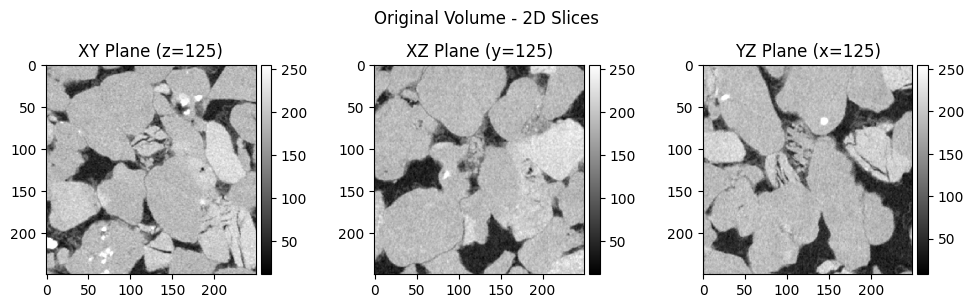

In [5]:
image_path = 'cropped_250.tif'
image_url = 'https://github.com/ArashRabbani/Py3DImage/raw/fb8c73c183ad7920fc6ff377131add790bf825d6/cropped_250.tif'

if not os.path.exists(image_path):
    response = requests.get(image_url)

    if 'blob' in image_url:
        parsed_url = urlparse(image_url)
        raw_url = f"https://raw.githubusercontent.com{parsed_url.path.replace('/blob/', '/')}"
        response = requests.get(raw_url)

    if response.status_code == 200:
        with open(image_path, 'wb') as f:
            f.write(response.content)

try:
    image_3d = tifffile.imread(image_path)

    print(f"Image shape: {image_3d.shape}")
    print(f"Data type: {image_3d.dtype}")
    print(f"Min value: {image_3d.min()}")
    print(f"Max value: {image_3d.max()}")
    print(f"Mean value: {image_3d.mean()}")

except Exception as e:
    print(f"Error loading the image: {e}")
# 2D Slice Visualization
def plot_2d_slices(volume, title="2D Slices Visualization"):
    # Get central slices
    z_slice = volume.shape[0] // 2
    y_slice = volume.shape[1] // 2
    x_slice = volume.shape[2] // 2

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

    # XY plane (top view)
    im1 = ax1.imshow(volume[z_slice, :, :], cmap='gray')
    ax1.set_title(f'XY Plane (z={z_slice})')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    # XZ plane
    im2 = ax2.imshow(volume[:, y_slice, :], cmap='gray')
    ax2.set_title(f'XZ Plane (y={y_slice})')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    # YZ plane
    im3 = ax3.imshow(volume[:, :, x_slice], cmap='gray')
    ax3.set_title(f'YZ Plane (x={x_slice})')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)

    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Display 2D slices of the original volume
fig_2d = plot_2d_slices(image_3d, "Original Volume - 2D Slices")
plt.show()

## Advanced Noise Reduction Techniques
We'll apply various filtering methods to reduce noise while preserving important features.
Each method has its strengths and is suitable for different types of noise and image features.

### 1. Basic Filtering Methods

**Gaussian Filter**
- Applies weighted average based on Gaussian distribution
- Use for: Smooth noise reduction while preserving edges better than uniform filter

**Median Filter**
- Replaces each voxel with median value of neighborhood
- Use for: Removing salt-and-pepper noise while preserving edges

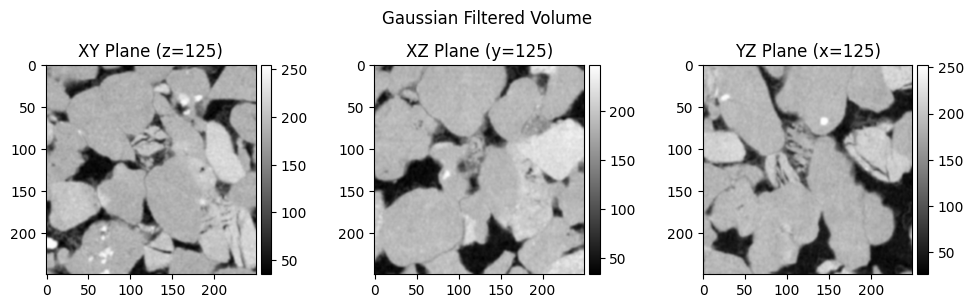

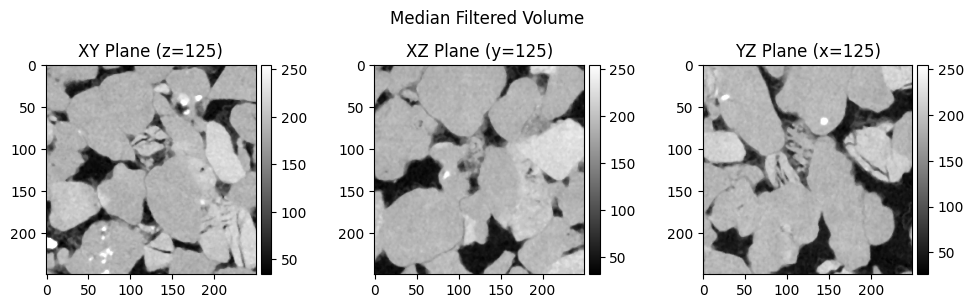

In [6]:
# Gaussian filtering
sigma = 1.0  # Standard deviation for Gaussian kernel
gaussian_filtered = ndimage.gaussian_filter(image_3d, sigma=sigma)

# Median filtering
size = 3  # Kernel size for median filter
median_filtered = ndimage.median_filter(image_3d, size=size)

# Display results
plot_2d_slices(gaussian_filtered, "Gaussian Filtered Volume")
plt.show()

plot_2d_slices(median_filtered, "Median Filtered Volume")
plt.show()

### 2. Advanced Filtering Methods

**Uniform/Mean Filter**
- Replaces each voxel with the average of its neighborhood
- Use for: General noise reduction and smoothing, good for Gaussian noise

**Maximum Filter**
- Replaces each voxel with the maximum value in its neighborhood
- Use for: Enhancing bright features, removing dark noise, dilation operations

**Minimum Filter**
- Replaces each voxel with the minimum value in its neighborhood  
- Use for: Enhancing dark features, removing bright noise, erosion operations

**Percentile Filter (75th)**
- Replaces each voxel with the 75th percentile value of its neighborhood
- Use for: Noise reduction while preserving bright structures better than median

**Rank Filter**
- Replaces each voxel with the kth smallest value in its neighborhood
- Use for: Customizable noise reduction, compromise between min/max filters

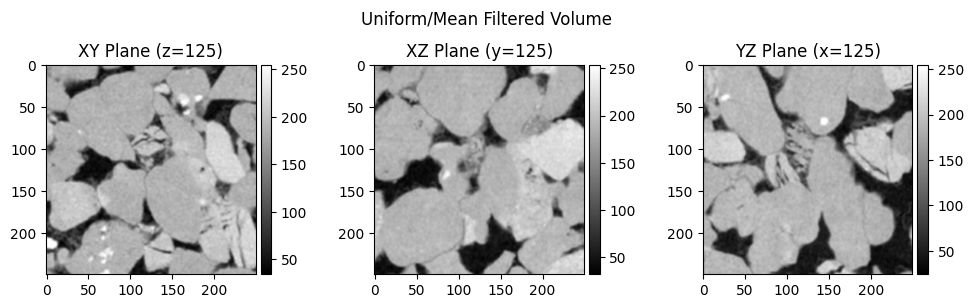

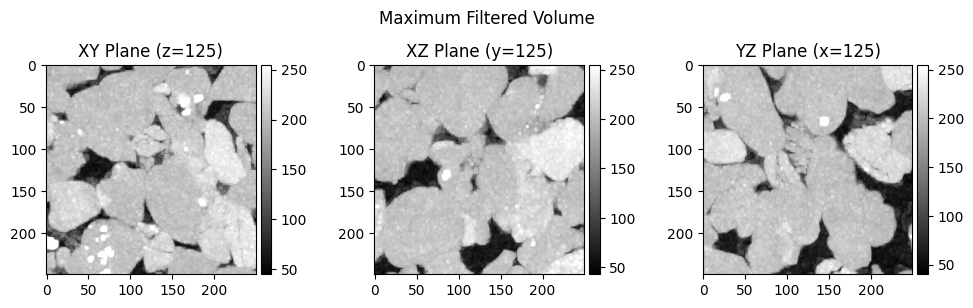

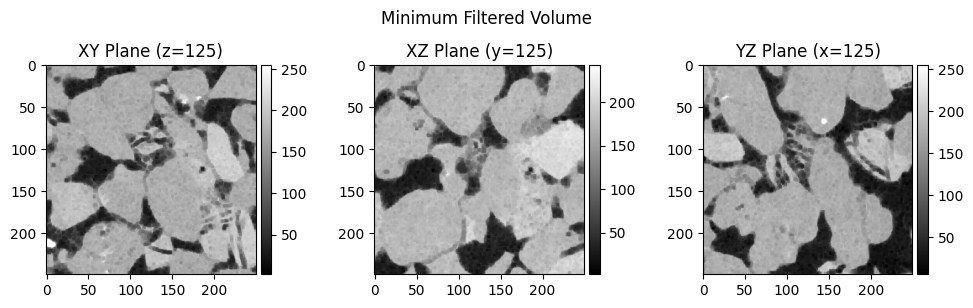

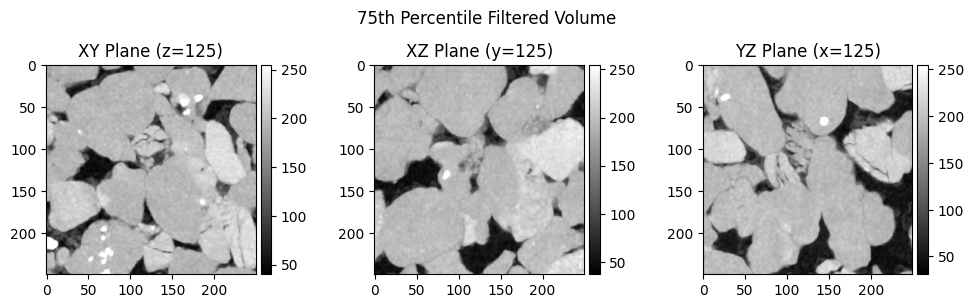

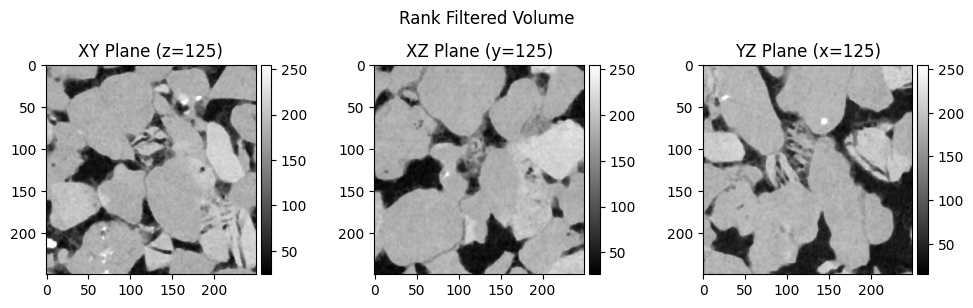

In [7]:
# Uniform/Mean filter
uniform_filtered = ndimage.uniform_filter(image_3d, size=3)
plot_2d_slices(uniform_filtered, "Uniform/Mean Filtered Volume")
plt.show()

# Maximum filter
max_filtered = ndimage.maximum_filter(image_3d, size=3)
plot_2d_slices(max_filtered, "Maximum Filtered Volume")
plt.show()

# Minimum filter
min_filtered = ndimage.minimum_filter(image_3d, size=3)
plot_2d_slices(min_filtered, "Minimum Filtered Volume")
plt.show()

# Percentile filter (75th percentile)
p75_filtered = ndimage.percentile_filter(image_3d, percentile=75, size=3)
plot_2d_slices(p75_filtered, "75th Percentile Filtered Volume")
plt.show()

# Rank filter
rank_filtered = ndimage.rank_filter(image_3d, rank=5, size=3)
plot_2d_slices(rank_filtered, "Rank Filtered Volume")
plt.show()


### 3. Filter Comparison and Analysis

This code computes quantitative metrics to evaluate different filtering methods:
- **MSE (Mean Squared Error)**: Measures how much the filtered image differs from the original. Lower values indicate the filter preserves original image features better.
- **SNR (Signal-to-Noise Ratio)**: Measured in decibels (dB), higher values indicate better noise reduction while preserving the important image signal.

Together, these metrics help assess the trade-off between noise reduction and feature preservation for each filter.

In [8]:
# Calculate metrics for each filter
def calculate_metrics(original, filtered):
    mse = np.mean((original - filtered) ** 2)
    snr = 10 * np.log10(np.var(original) / mse) if mse > 0 else float('inf')
    return mse, snr

# Dictionary of all filters
filters_dict = {
    'Gaussian': gaussian_filtered,
    'Median': median_filtered,
    'Uniform': uniform_filtered,
    'Maximum': max_filtered,
    'Minimum': min_filtered,
    'Percentile-75': p75_filtered,
    'Rank': rank_filtered
}

# Print metrics table
print("Filter Performance Metrics:")
print("-" * 50)
print(f"{'Filter Name':<25} {'MSE':>10} {'SNR (dB)':>10}")
print("-" * 50)
for name, filtered_img in filters_dict.items():
    mse, snr = calculate_metrics(image_3d, filtered_img)
    print(f"{name:<25} {mse:>10.2f} {snr:>10.2f}")

Filter Performance Metrics:
--------------------------------------------------
Filter Name                      MSE   SNR (dB)
--------------------------------------------------
Gaussian                       54.44      16.28
Median                         45.43      17.06
Uniform                        51.98      16.48
Maximum                       103.79      13.48
Minimum                       105.05      13.42
Percentile-75                  66.05      15.44
Rank                           72.11      15.06


## Intensity adjustments
For an input image 'I' with intensity values in [0,255], we can adjust both brightness and contrast to effectively use the complete space of the image.
For brightness adjustment:
$$I_{bright} = b \times I$$
where b > 1 increases brightness, b < 1 decreases brightness
Contrast adjustment:
$$I_{contrast} = (I - 127.5) \times c + 127.5$$
where c > 1 increases contrast, c < 1 decreases contrast
The 127.5 offset centers the scaling around the middle of the intensity range for 8-bit images. Both formulas require final clipping to maintain valid 8-bit range.

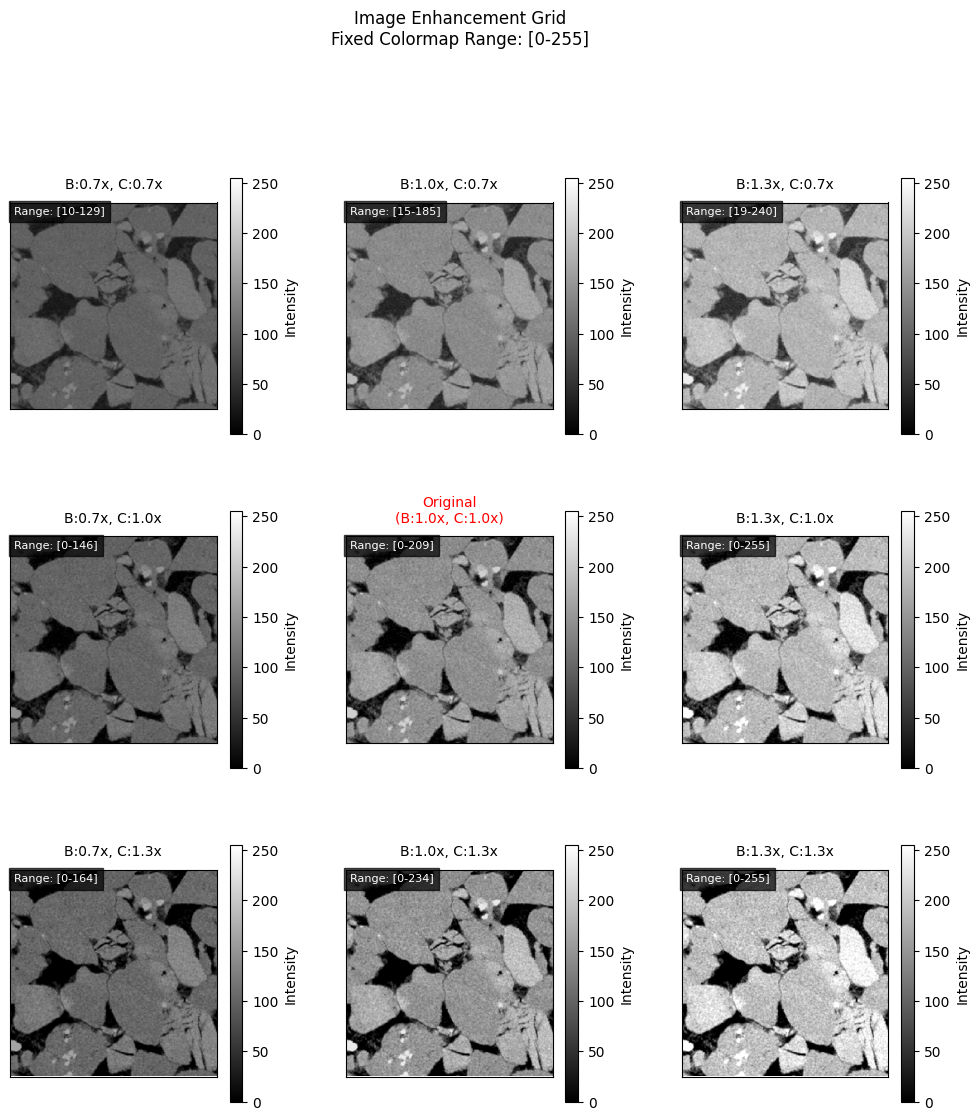

In [10]:
import numpy as np
import tifffile
from skimage import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt

def create_enhancement_grid(image_3d):
    # Select a representative slice
    slice_idx = image_3d.shape[0] // 2
    slice_2d = image_3d[slice_idx]

    # Convert to float for processing
    img_float = img_as_float(slice_2d)

    # Define brightness and contrast factors
    brightness_factors = [0.7, 1.0, 1.3]  # darker, original, brighter
    contrast_factors = [0.7, 1.0, 1.3]    # lower, original, higher

    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Create all combinations
    for i, contrast in enumerate(contrast_factors):
        for j, brightness in enumerate(brightness_factors):
            # Apply contrast first, then brightness
            enhanced = img_float * contrast  # contrast
            enhanced = enhanced - enhanced.mean() + 0.5  # center around 0.5
            enhanced = enhanced * brightness  # brightness
            enhanced = np.clip(enhanced, 0, 1)  # ensure valid range
            enhanced = img_as_ubyte(enhanced)  # convert back to uint8

            # Plot with fixed vmin and vmax
            im = axes[i, j].imshow(enhanced, cmap='gray', vmin=0, vmax=255)
            cbar = plt.colorbar(im, ax=axes[i, j])
            cbar.set_label('Intensity')

            # Add title
            if i == 1 and j == 1:
                axes[i, j].set_title('Original\n(B:1.0x, C:1.0x)',
                                   color='red',
                                   pad=10,
                                   fontsize=10)
            else:
                axes[i, j].set_title(f'B:{brightness:.1f}x, C:{contrast:.1f}x',
                                   pad=10,
                                   fontsize=10)

            # Remove ticks for cleaner look
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            # Add pixel value range information
            axes[i, j].text(0.02, 0.98,
                          f'Range: [{enhanced.min()}-{enhanced.max()}]',
                          transform=axes[i, j].transAxes,
                          color='white',
                          bbox=dict(facecolor='black', alpha=0.7),
                          verticalalignment='top',
                          fontsize=8)

    # Add overall title
    plt.suptitle('Image Enhancement Grid\nFixed Colormap Range: [0-255]',
                y=1.02,
                fontsize=12)

    # Adjust layout
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    return fig

# Load and process the image
image_path = 'cropped_250.tif'
image_3d = tifffile.imread(image_path)

# Create and display the enhancement grid
fig = create_enhancement_grid(image_3d)
plt.show()

## Image Thresholding Techniques
Three different thresholding approaches are implemented for image segmentation:

- **Otsu's Method**: Global thresholding that automatically calculates an optimal threshold by maximizing the variance between foreground and background pixel classes. Works best when the image histogram has two distinct peaks.

- **Adaptive Thresholding**: Calculates thresholds locally using a sliding window (block_size=35). For each pixel, the threshold is computed based on the mean or gaussian-weighted mean of its neighborhood. Particularly effective for images with varying lighting conditions or intensity gradients.

- **Yen's Method**: The Yen algorithm finds the optimal threshold by minimizing the log of the product of foreground and background variances. It often performs better than Otsu for low contrast images.


Applying Adaptive thresholding...
Adaptive thresholding processing time: 1.07 seconds


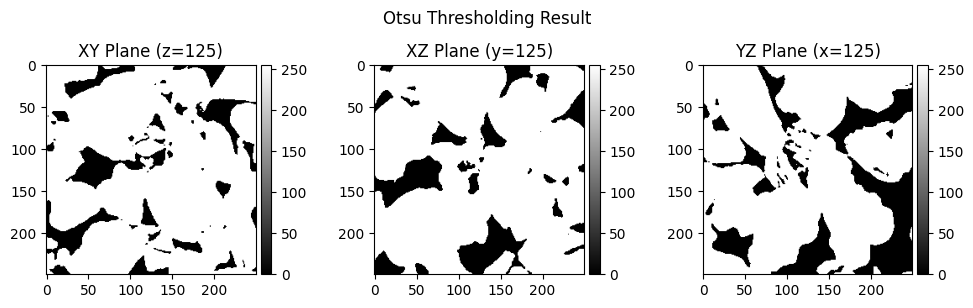

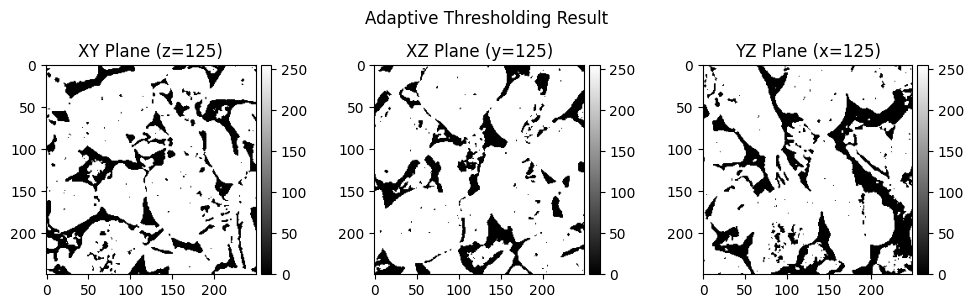

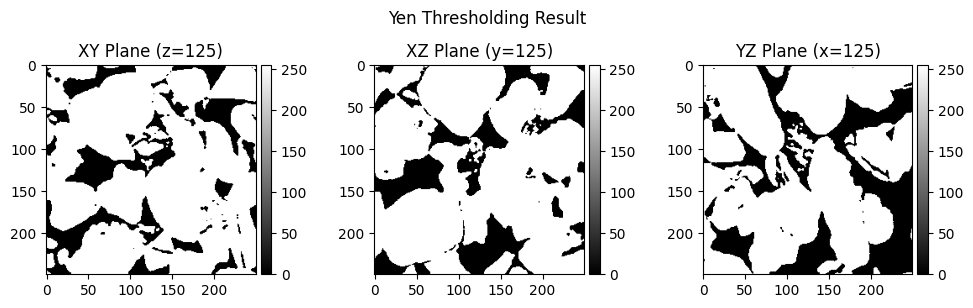


Thresholding Method Comparison:
--------------------------------------------------
Method               Threshold Value Object Fraction
--------------------------------------------------
Otsu                 135.00          0.822          
Adaptive             Local           0.810          
Yen                  169.00          0.762          


In [11]:
# 1. Global Otsu thresholding (already shown above)
otsu_threshold = filters.threshold_otsu(median_filtered)
otsu_binary = median_filtered > otsu_threshold

# 2. Adaptive thresholding
def adaptive_threshold_3d(volume, block_size=35, offset=10):
    binary = np.zeros_like(volume, dtype=bool)
    for i in range(volume.shape[0]):
        # Calculate local threshold for each slice
        local_thresh = filters.threshold_local(
            volume[i],
            block_size=block_size,
            offset=offset,
            method='gaussian'
        )
        binary[i] = volume[i] > local_thresh
    return binary

print("Applying Adaptive thresholding...")
start_time = time.time()
adaptive_binary = adaptive_threshold_3d(median_filtered)
print(f"Adaptive thresholding processing time: {time.time() - start_time:.2f} seconds")

# 3. Yen's thresholding method
yen_threshold = filters.threshold_yen(median_filtered)
yen_binary = median_filtered > yen_threshold

# Display thresholding results
plot_2d_slices(otsu_binary.astype(np.uint8) * 255, "Otsu Thresholding Result")
plt.show()

plot_2d_slices(adaptive_binary.astype(np.uint8) * 255, "Adaptive Thresholding Result")
plt.show()

plot_2d_slices(yen_binary.astype(np.uint8) * 255, "Yen Thresholding Result")
plt.show()

# Compare thresholding methods
print("\nThresholding Method Comparison:")
print("-" * 50)
print(f"{'Method':<20} {'Threshold Value':<15} {'Object Fraction':<15}")
print("-" * 50)
print(f"{'Otsu':<20} {otsu_threshold:<15.2f} {np.mean(otsu_binary):<15.3f}")
print(f"{'Adaptive':<20} {'Local':<15} {np.mean(adaptive_binary):<15.3f}")
print(f"{'Yen':<20} {yen_threshold:<15.2f} {np.mean(yen_binary):<15.3f}")

## Binary Operations
Now we'll clean up the binary image using morphological operations

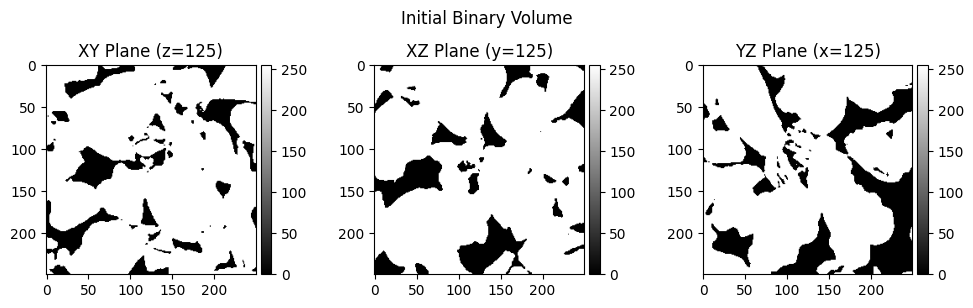

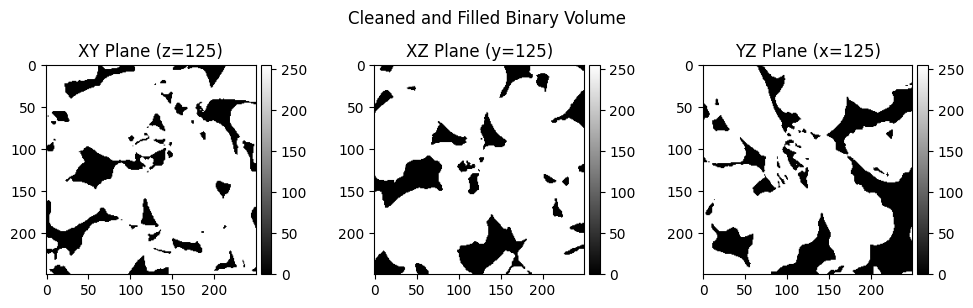

In [12]:
# Remove small objects
binary_image=otsu_binary
min_size = 100  # Minimum size of objects to keep
cleaned = morphology.remove_small_objects(binary_image, min_size=min_size)

# Fill holes
filled = ndimage.binary_fill_holes(cleaned)

# Display cleaned and filled result
plot_2d_slices(otsu_binary.astype(np.uint8) * 255, "Initial Binary Volume")
plt.show()
# Display cleaned and filled result
plot_2d_slices(filled.astype(np.uint8) * 255, "Cleaned and Filled Binary Volume")
plt.show()

## 3D visualization
The binary volumes can be visulized using plotly for better understanding of the 3D structures and connectivity

In [ ]:
import plotly.graph_objects as go     # For interactive 3D volume visualization
def show_cube(volume):
    # Get dimensions
    nx, ny, nz = volume.shape

    # Convert boolean data to float if necessary
    if volume.dtype == bool:
        volume = volume.astype(float)

    # Get global min and max for consistent color scaling
    vmin = float(volume.min())
    vmax = float(volume.max())

    # Create coordinate arrays
    x = np.arange(nx)
    y = np.arange(ny)
    z = np.arange(nz)

    # Create meshgrids for each plane orientation
    X_xy, Y_xy = np.meshgrid(x, y)
    X_xz, Z_xz = np.meshgrid(x, z)
    Y_yz, Z_yz = np.meshgrid(y, z)

    # Create figure
    fig = go.Figure()

    # Front face (y = 0)
    fig.add_trace(go.Surface(
        x=X_xz,
        y=np.zeros_like(X_xz),
        z=Z_xz,
        surfacecolor=volume[:, 0, :].T.astype(float),
        colorscale='Greys_r',
        name='Front',
        showscale=True,
        cmin=vmin,
        cmax=vmax
    ))

    # Back face (y = ny-1)
    fig.add_trace(go.Surface(
        x=X_xz,
        y=np.full_like(X_xz, ny-1),
        z=Z_xz,
        surfacecolor=volume[:, -1, :].T.astype(float),
        colorscale='Greys_r',
        name='Back',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))

    # Left face (x = 0)
    fig.add_trace(go.Surface(
        x=np.zeros_like(Y_yz),
        y=Y_yz,
        z=Z_yz,
        surfacecolor=volume[0, :, :].T.astype(float),
        colorscale='Greys_r',
        name='Left',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))

    # Right face (x = nx-1)
    fig.add_trace(go.Surface(
        x=np.full_like(Y_yz, nx-1),
        y=Y_yz,
        z=Z_yz,
        surfacecolor=volume[-1, :, :].T.astype(float),
        colorscale='Greys_r',
        name='Right',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))

    # Bottom face (z = 0)
    fig.add_trace(go.Surface(
        x=X_xy.T,
        y=Y_xy.T,
        z=np.zeros_like(X_xy.T),
        surfacecolor=volume[:, :, 0].astype(float),
        colorscale='Greys_r',
        name='Bottom',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))

    # Top face (z = nz-1)
    fig.add_trace(go.Surface(
        x=X_xy.T,
        y=Y_xy.T,
        z=np.full_like(X_xy.T, nz-1),
        surfacecolor=volume[:, :, -1].astype(float),
        colorscale='Greys_r',
        name='Top',
        showscale=False,
        cmin=vmin,
        cmax=vmax
    ))

    # Update layout with better default view
    fig.update_layout(
        title='3D Volume Visualization (All 6 Faces)',
        scene=dict(
            xaxis_title='X (voxels)',
            yaxis_title='Y (voxels)',
            zaxis_title='Z (voxels)',
            aspectmode='data',
            camera=dict(
                eye=dict(x=2, y=2, z=1.5),
                up=dict(x=0, y=0, z=1)
            )
        ),
        width=800,
        height=800
    )

    return fig

# Create and display the visualization
print("\nCreating visualization...")
fig = show_cube(filled)
fig.show()

print("\nVisualization controls:")
print("- Rotate: Click and drag")
print("- Zoom: Scroll wheel")
print("- Pan: Right-click and drag")



## Save Results
Save our processed binary image for future use.

In [ ]:
# Save binary result
tifffile.imwrite('binary_result.tif', filled.astype(np.uint8) * 255)